In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 
from pprint import pp

# Data import en opschonen

In [2]:
data = pd.read_csv("../data/train.csv", delimiter=';')
data["overcrowding"] = data["overcrowding"].str.replace(",", ".").astype("float")
data["meaneduc"] = data["meaneduc"].str.replace(",", ".").astype("float")

In [3]:
X = data.drop(columns="target")
y = data["target"]

In [4]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1, train_size=0.7)

# 1x Random Forest trainen

In [20]:
# clf = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=10, n_jobs=-1, ccp_alpha=0.5, max_features=50)
params = {
    'n_estimators': 775,
    'min_samples_split': 2,
    'max_features': 50,
    'max_depth': 41,
    'criterion': 'entropy'
    }

clf = RandomForestClassifier(**params, n_jobs=-1, random_state=1)
clf = clf.fit(train_X, train_y)

In [21]:
clf.score(val_X, val_y)

0.9384816753926701

# Hyper parameter estimation

In [9]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# n_trees = [int(x) for x in np.linspace(start = 775, stop = 900, num = 10)]
# max_depth = [int(x) for x in np.linspace(start = 15, stop = 50, num = 5)]
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 15, num = 5)]
# max_features = [int(x) for x in np.linspace(start = 20, stop = 50, num = 5)]
# criterion = ['gini', 'entropy']

n_trees = [775]
max_depth = [41]
min_samples_split = [2]
max_features = [int(x) for x in np.arange(1,90)]
criterion = ['entropy']

param_grid = [
    {
        'n_estimators': n_trees,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'max_features':max_features, 
        'criterion': criterion,
        'random_state': [1]
    },
]

# grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, refit = True, n_jobs=-1, cv=5, n_iter=100, verbose=0, random_state=1) 
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, n_jobs=-1, cv=5, verbose=3) 

In [10]:
# fitting the model for grid search 
grid.fit(train_X, train_y) 

Fitting 5 folds for each of 89 candidates, totalling 445 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['entropy'], 'max_depth': [41],
                          'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14, 15, 16, 17, 18, 19, 20,
                                           21, 22, 23, 24, 25, 26, 27, 28, 29,
                                           30, ...],
                          'min_samples_split': [2], 'n_estimators': [775]}],
             verbose=3)

In [11]:
# print best parameter after tuning 
pp(grid.best_params_) 
grid_predictions = grid.predict(val_X) 

# print classification report 
print("\n______________________________________________________")
print("Classification report: \n" + classification_report(val_y, grid_predictions)) 

{'criterion': 'entropy',
 'max_depth': 41,
 'max_features': 86,
 'min_samples_split': 2,
 'n_estimators': 775}

______________________________________________________
Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1467
           1       0.92      0.92      0.92       825

    accuracy                           0.94      2292
   macro avg       0.94      0.94      0.94      2292
weighted avg       0.94      0.94      0.94      2292



## Model overfitting analysis

In [22]:
# clf = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=10, n_jobs=-1, ccp_alpha=0.5, max_features=50)
train_score, val_score = [], []
depths = np.arange(1, 40)
for depth in depths:
    params = {
        'n_estimators': 775,
        'min_samples_split': 2,
        'max_features': 50,
        'max_depth': depth,
        'criterion': 'entropy'
        }
    clf = RandomForestClassifier(**params, n_jobs=-1, random_state=1)
    clf = clf.fit(train_X, train_y)
    train_score.append(clf.score(train_X, train_y))
    val_score.append(clf.score(val_X, val_y))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


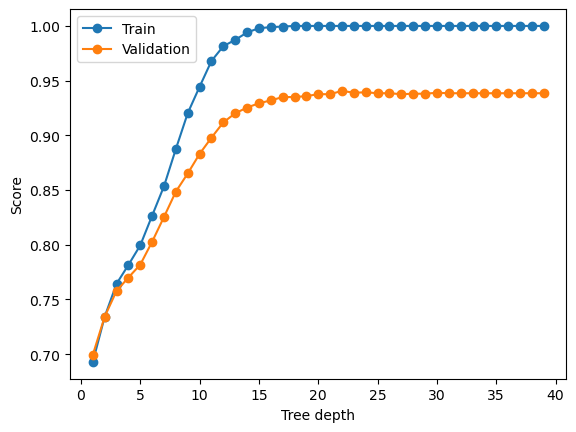

In [23]:
plt.plot(depths, train_score, '-o', label='Train')
plt.plot(depths, val_score, '-o', label='Validation')
plt.legend()
plt.xlabel("Tree depth")
plt.ylabel("Score")
plt.savefig("../img/overfit_plot.eps")
plt.show()